<a href="https://colab.research.google.com/github/harish-babu/stash-ai-ml-models/blob/main/Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os
import pathlib

import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [ ]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

2.15.0


In [ ]:
# While the variable is named gdrive_src_path, it really is the base path for the source file 'Project_data.zip'

gdrive_src_path = '/content/gdrive/MyDrive/RNN-Gesture-Recognition'             # For running from Google Drive
# gdrive_src_path = '/content/gdrive/MyDrive/RNN-Gesture-Recognition'           # For local running of notebook

In [ ]:
# Define a base path.  It can be changed when moving from colab to local
base_path = "/content/Gesture-Recognition"        # This is for google drive
# base_path = "/content"                          # This is for local data on the GPU m/c
# base_path = "."                                 # This is for local


In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
import pathlib
from pathlib import Path
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile
with ZipFile(gdrive_src_path + '/Project_data.zip','r') as zip:
  zip.extractall(base_path)

Setting some paths for the train and validation set.  

In [ ]:
train_path =  base_path + "/Project_data/train"
val_path =  base_path + "/Project_data/val"
train_doc = np.random.permutation(open(base_path + '/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(base_path + '/Project_data/val.csv').readlines())
num_classes = 5  #number of softmax classes

In [ ]:
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

#### Utitlity Functions

In [ ]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [ ]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = gdrive_src_path + '/Models/' + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # This code handles the remaining data points after forming full batches in training.
        # It initializes arrays for the remaining batch's data and labels.
        # It then loops over the remaining folders, reads and processes each image, and stores it in the batch_data array.
        # The corresponding label is set in the batch_labels array.
        # The code yields the batch_data and batch_labels arrays, creating a generator for memory efficiency.
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(remaining_batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Apply random transformations to some images if 'augment' is True
                    if augment and np.random.randn() > 0:
                      image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels).

## Model
In the process of constructing the model, we'll be utilizing various functionalities provided by Keras. It's important to note that we'll be employing `Conv3D` and `MaxPooling3D` for a 3D convolution model, instead of `Conv2D` and `MaxPooling2D`. When building a Conv2D + RNN model, the `TimeDistributed` layer will be used. The final layer of the model will be a softmax layer. The design of the network is aimed to achieve high accuracy with the least number of parameters, ensuring that the model can fit within the memory constraints of a webcam. All these considerations are taken into account to ensure the model's effectiveness and efficiency.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

#Conv3D Models

In [ ]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

##Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 30, 120, 120, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 60, 60, 16)    0         
 D)                                                              
                                                              

In [ ]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)


In [ ]:
history_model_conv3D_1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                            callbacks=callbacks_list, validation_data=val_generator,
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-17-077818d29777>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_conv3D_1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-12-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
66/67 [============================>.] - ETA: 2s - loss: 1.4233 - categorical_accuracy: 0.4818

<ipython-input-12-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.4251 - categorical_accuracy: 0.4811
Epoch 1: val_loss improved from inf to 2.47997, saving model to /content/gdrive/MyDrive/RNN-Gesture-Recognition/Models/model_conv3D_1_2024-04-0303_09_22.956139/model-00001-1.42512-0.48115-2.47997-0.25000.h5
67/67 [==============================] - 210s 3s/step - loss: 1.4251 - categorical_accuracy: 0.4811 - val_loss: 2.4800 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/67 [==============================] - ETA: 0s - loss: 1.1071 - categorical_accuracy: 0.5777
Epoch 2: val_loss did not improve from 2.47997
67/67 [==============================] - 179s 3s/step - loss: 1.1071 - categorical_accuracy: 0.5777 - val_loss: 3.2459 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9785 - categorical_accuracy: 0.6214
Epoch 3: val_loss did not improve from 2.47997
67/67 [==============================] - 185s 3s/step - loss: 0.9785 - categorical_accuracy: 0.6214 - val_loss: 3.0270 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 4/25
67/67 [==============================] - ETA: 0s - loss: 0.8320 - categorical_accuracy: 0.6501
Epoch 4: val_loss did not improve from 2.47997

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
67/67 [==============================] - 175s 3s/step - loss: 0.8320 - categorical_accuracy: 0.6501 - val_loss: 3.9203 - val_categorical_acc

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


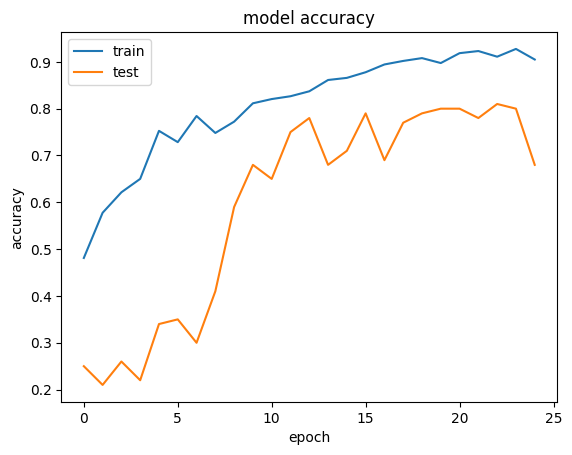

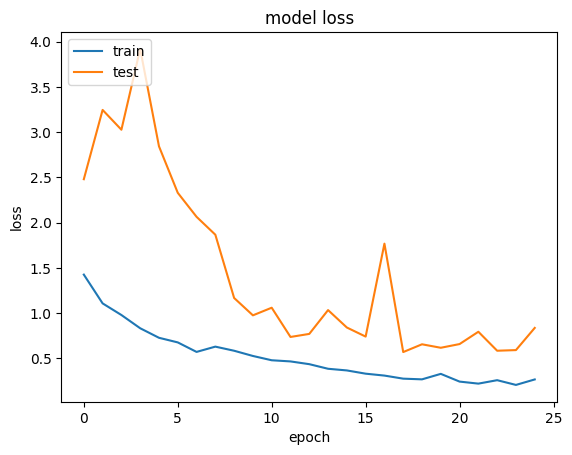

In [ ]:
plot_loss_accuracy(history_model_conv3D_1)


##Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_6 (Bat  (None, 20, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 10, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_

In [ ]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history_model_conv3D_2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-21-5c3dcdbec0a4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_conv3D_2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-12-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
66/67 [============================>.] - ETA: 1s - loss: 1.4929 - categorical_accuracy: 0.4697

<ipython-input-12-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.4957 - categorical_accuracy: 0.4691
Epoch 1: val_loss improved from inf to 2.58243, saving model to /content/gdrive/MyDrive/RNN-Gesture-Recognition/Models/model_conv3D_2_2024-04-0303_09_22.956139/model-00001-1.49570-0.46908-2.58243-0.31000.h5
67/67 [==============================] - 126s 2s/step - loss: 1.4957 - categorical_accuracy: 0.4691 - val_loss: 2.5824 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0888 - categorical_accuracy: 0.5943
Epoch 2: val_loss did not improve from 2.58243
67/67 [==============================] - 137s 2s/step - loss: 1.0888 - categorical_accuracy: 0.5943 - val_loss: 3.6511 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.0154 - categorical_accuracy: 0.6109
Epoch 3: val_loss did not improve from 2.58243
67/67 [==============================] - 120s 2s/step - lo

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


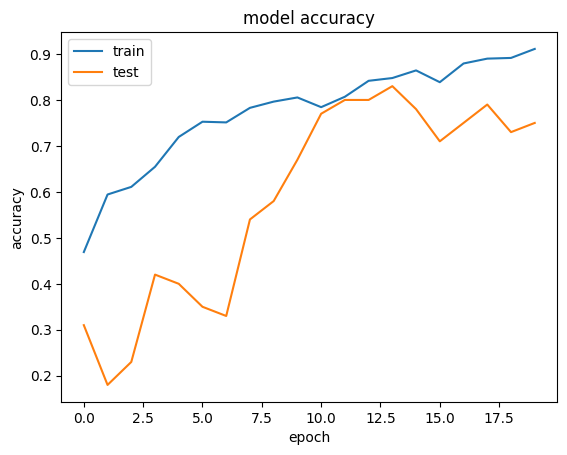

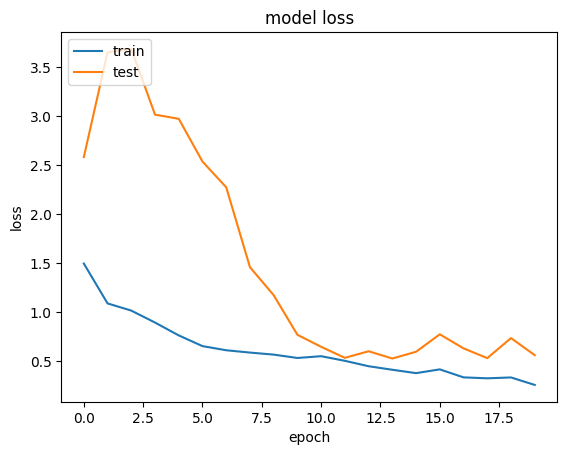

In [ ]:
plot_loss_accuracy(history_model_conv3D_2)

##Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [ ]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_12 (Ba  (None, 30, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 15, 60, 60, 16)    0         
 g3D)                                                            
                                                            

In [ ]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history_model_conv3D_3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-25-9ca23891ea93>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_conv3D_3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-12-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
66/67 [============================>.] - ETA: 2s - loss: 1.5568 - categorical_accuracy: 0.4303

<ipython-input-12-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5611 - categorical_accuracy: 0.4299
Epoch 1: val_loss improved from inf to 4.29943, saving model to /content/gdrive/MyDrive/RNN-Gesture-Recognition/Models/model_conv3D_3_2024-04-0303_09_22.956139/model-00001-1.56112-0.42986-4.29943-0.21000.h5
67/67 [==============================] - 229s 3s/step - loss: 1.5611 - categorical_accuracy: 0.4299 - val_loss: 4.2994 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.0615 - categorical_accuracy: 0.6048
Epoch 2: val_loss did not improve from 4.29943
67/67 [==============================] - 215s 3s/step - loss: 1.0615 - categorical_accuracy: 0.6048 - val_loss: 4.3403 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.2209 - categorical_accuracy: 0.5490
Epoch 3: val_loss did not improve from 4.29943
67/67 [==============================] - 220s 3s/step - lo

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


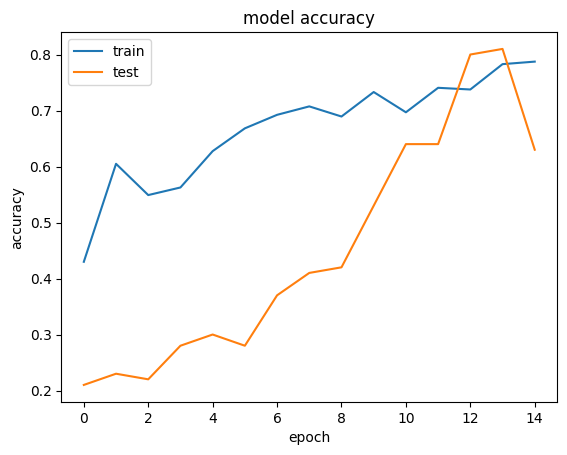

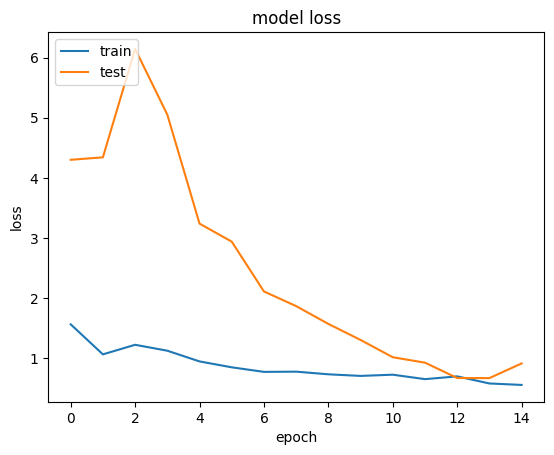

In [ ]:
plot_loss_accuracy(history_model_conv3D_3)

##Conv 3D Model with 30 frames per video and a 5 by 5 filter size (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [ ]:
def conv3D_5by5(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D_5by5(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 16   6016      
                             )                                   
                                                                 
 activation_21 (Activation)  (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_18 (Ba  (None, 30, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                            

In [ ]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history_model_conv3D_4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-30-fe0eb2a284f3>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_conv3D_4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-12-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
65/67 [============================>.] - ETA: 4s - loss: 1.6761 - categorical_accuracy: 0.4200

<ipython-input-12-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.6723 - categorical_accuracy: 0.4223
Epoch 1: val_loss improved from inf to 3.27473, saving model to /content/gdrive/MyDrive/RNN-Gesture-Recognition/Models/model_conv3D_4_2024-04-0303_09_22.956139/model-00001-1.67230-0.42232-3.27473-0.22000.h5
67/67 [==============================] - 206s 3s/step - loss: 1.6723 - categorical_accuracy: 0.4223 - val_loss: 3.2747 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.3750 - categorical_accuracy: 0.4872
Epoch 2: val_loss improved from 3.27473 to 1.71368, saving model to /content/gdrive/MyDrive/RNN-Gesture-Recognition/Models/model_conv3D_4_2024-04-0303_09_22.956139/model-00002-1.37505-0.48718-1.71368-0.41000.h5
67/67 [==============================] - 188s 3s/step - loss: 1.3750 - categorical_accuracy: 0.4872 - val_loss: 1.7137 - val_categorical_accuracy: 0.4100 - lr: 0.0010
Epoch 3/15
67/67 [=============================

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


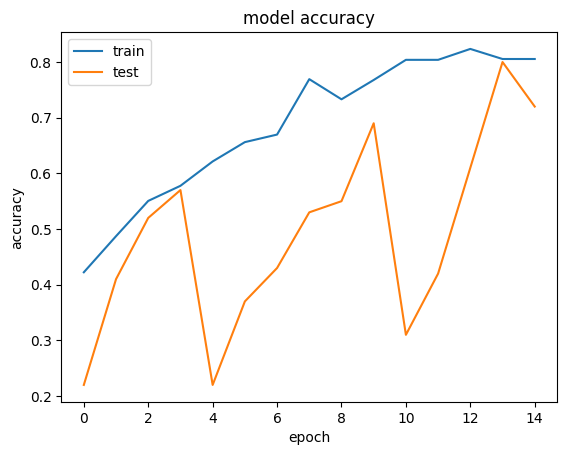

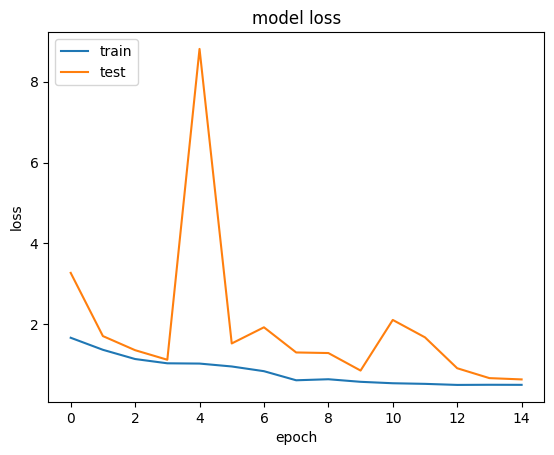

In [ ]:
plot_loss_accuracy(history_model_conv3D_4)

#TRANSFER LEARNING - MobileNet Conv2d + GRU

We are going to build two models using pre-trained models.  We are going to do transfer learning and train the weights on the new inputs.

In [ ]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

##Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
17225924/17225924 [==============================] - 0s 0us/step
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 3, 3, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 1024)          0         
 stri

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history_model_retrain_mobilenet_gru = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-35-fae4ced237f5>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_retrain_mobilenet_gru = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-12-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 3s - loss: 1.1455 - categorical_accuracy: 0.5754

<ipython-input-12-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.1452 - categorical_accuracy: 0.5747
Epoch 1: val_loss improved from inf to 0.91668, saving model to /content/gdrive/MyDrive/RNN-Gesture-Recognition/Models/model_retrain_mobilenet_gru_2024-04-0303_09_22.956139/model-00001-1.14518-0.57466-0.91668-0.62000.h5
67/67 [==============================] - 149s 2s/step - loss: 1.1452 - categorical_accuracy: 0.5747 - val_loss: 0.9167 - val_categorical_accuracy: 0.6200 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6000 - categorical_accuracy: 0.7541
Epoch 2: val_loss improved from 0.91668 to 0.39063, saving model to /content/gdrive/MyDrive/RNN-Gesture-Recognition/Models/model_retrain_mobilenet_gru_2024-04-0303_09_22.956139/model-00002-0.60004-0.75415-0.39063-0.88000.h5
67/67 [==============================] - 125s 2s/step - loss: 0.6000 - categorical_accuracy: 0.7541 - val_loss: 0.3906 - val_categorical_accuracy: 0.8800 - lr: 0.0010
Epoch 3/20
67/67 [===

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


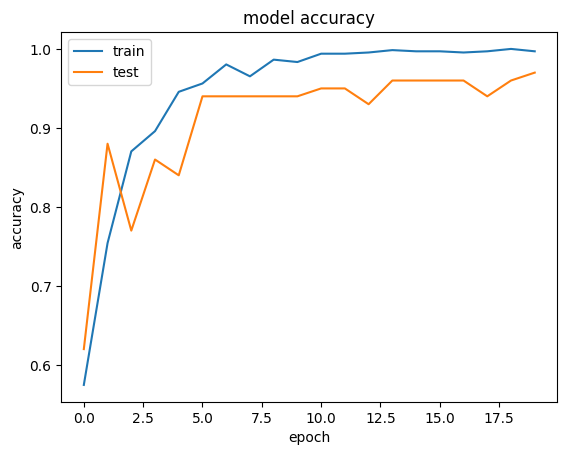

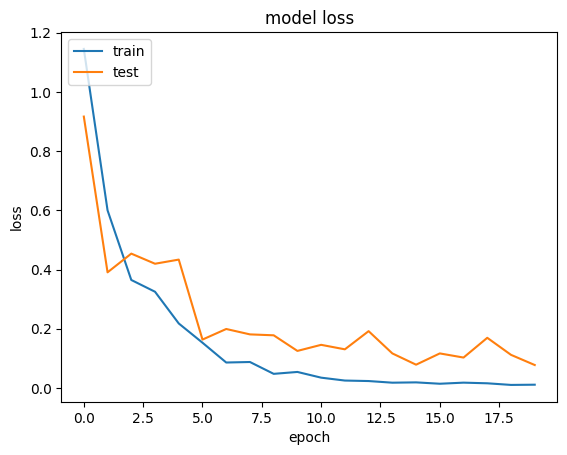

In [ ]:
plot_loss_accuracy(history_model_retrain_mobilenet_gru)

##Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes

In [ ]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 20, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
    

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history_model_retrain_mobilenet_lstm = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-39-362956b7ebad>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_retrain_mobilenet_lstm = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
<ipython-input-12-2d7ac75b5085>:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 3s - loss: 1.2195 - categorical_accuracy: 0.4985

<ipython-input-12-2d7ac75b5085>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2281 - categorical_accuracy: 0.4932
Epoch 1: val_loss improved from inf to 0.81297, saving model to /content/gdrive/MyDrive/RNN-Gesture-Recognition/Models/model_retrain_mobilenet_lstm_2024-04-0303_09_22.956139/model-00001-1.22811-0.49321-0.81297-0.69000.h5
67/67 [==============================] - 148s 2s/step - loss: 1.2281 - categorical_accuracy: 0.4932 - val_loss: 0.8130 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.7892 - categorical_accuracy: 0.6817
Epoch 2: val_loss improved from 0.81297 to 0.74627, saving model to /content/gdrive/MyDrive/RNN-Gesture-Recognition/Models/model_retrain_mobilenet_lstm_2024-04-0303_09_22.956139/model-00002-0.78922-0.68175-0.74627-0.63000.h5
67/67 [==============================] - 127s 2s/step - loss: 0.7892 - categorical_accuracy: 0.6817 - val_loss: 0.7463 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 3/20
67/67 [=

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


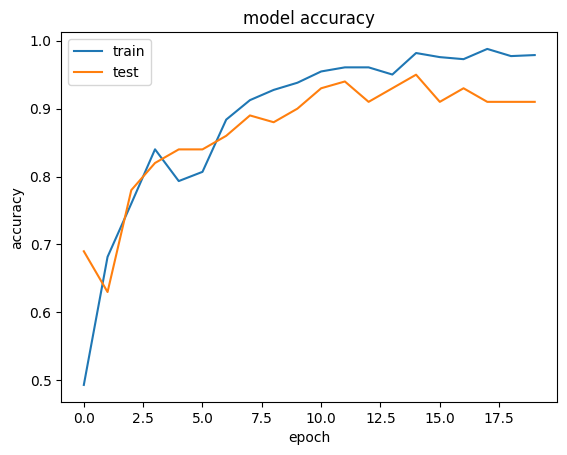

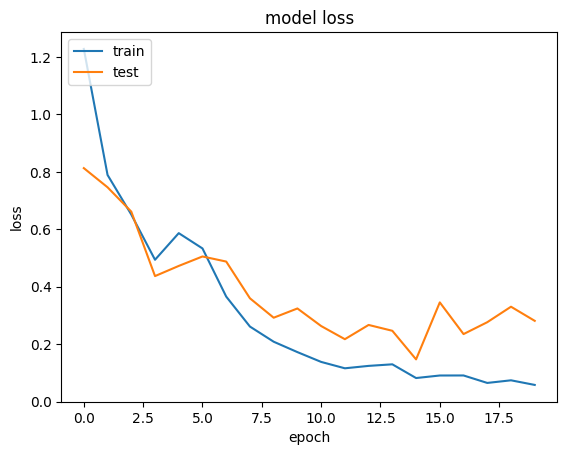

In [ ]:
plot_loss_accuracy(history_model_retrain_mobilenet_lstm)